## Spatial Analysis

According to the so-called "[First Law of Geography](https://en.wikipedia.org/wiki/Tobler%27s_first_law_of_geography)", things that happen in a place are likely to also happen at nearby locations. This relationship can be positive if similar values are close to each other, or negative if distant.

From the previous choropleth maps, I expect vaw data to have some spatial correlation. To formally prove this intuition, proceed by:

1) investigating whether VAW generally follow a particular pattern in its geographical distribution (**Global spatial autocorrelation**)

2) detecting where clusters are (**Local Spatial Autocorrelation**)



Required modules*:

- Pysal for KNN and spatial lag
- Esda for calculating Moran’s I (global and local)
- Splot for plotting Moran's I scatterplot and LISA clusters


<span style="white-space: pre"> 
<span style="white-space: pre">

*exclude modules presented in previous steps

In [1]:
# Import required modules
import geopandas as gpd
import matplotlib.pyplot as plt

# spatial analysis
import libpysal as lps
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

# additional: avoid warnings messages
import warnings
warnings.filterwarnings('ignore')

Import the spatial VAW data
(processed in the previous data preparation step).

In [2]:
# Read the data
gdf = gpd.read_file('data/VAW_AGEB_clean.gjson')

## Global spatial autocorrelation


The first step is to determine what to consider as neighbors and compute the spatial weights accordingly. I'll use the k-nearest neighbours weight (with $k = 8$) which assigns neighbors based on distance by finding the (eight) closest neighbors based on the centroid of each geography. 

In [3]:
# calculate spatial weight
w_knn = lps.weights.KNN.from_dataframe(gdf, k=8)


Now I need to proceed with the row-standardization. This computation adjusts the spatial weights matrix dividing each weight by its row sum. 

In [4]:
# Row-standardization
w_knn.transform = 'R'

Plot the k-nearest neighbours map

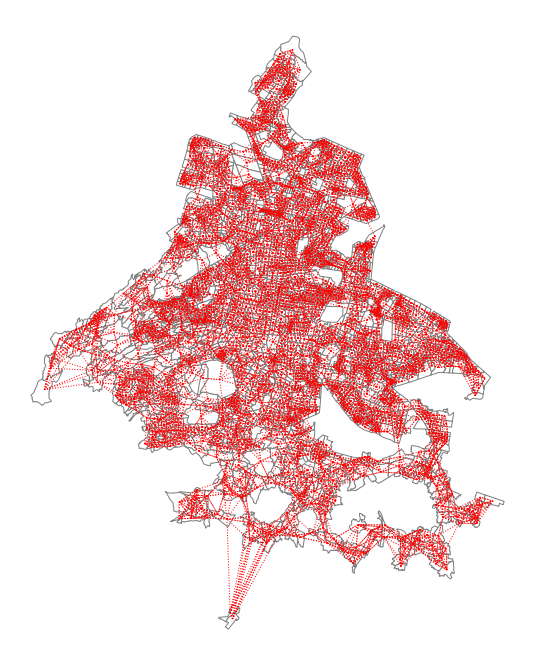

In [5]:
ax = gdf.plot(edgecolor='grey', facecolor='w', figsize=(12,12))

f,ax = w_knn.plot(gdf, 
                  ax=ax, 
        edge_kws=dict(color='r', 
                      linestyle=':',
                      linewidth=1),
        node_kws=dict(marker=''))

ax.set_axis_off()

With a relatively high number of neighbors and small geometries, the map is not visually attractive. Still, it helps to get a better idea of the KNN relationships among the spatial units.

**Compute Spatial lag**

Now use Pysal to compute the spatial lag of VAW per 1000. 

In [6]:
# compute the spatial lag
gdf['VAW_per_1000_LAG'] = lps.weights.lag_spatial(w_knn, gdf['VAW_per_1000'])

And compare the map of violence per 1000 with the spatial lag.

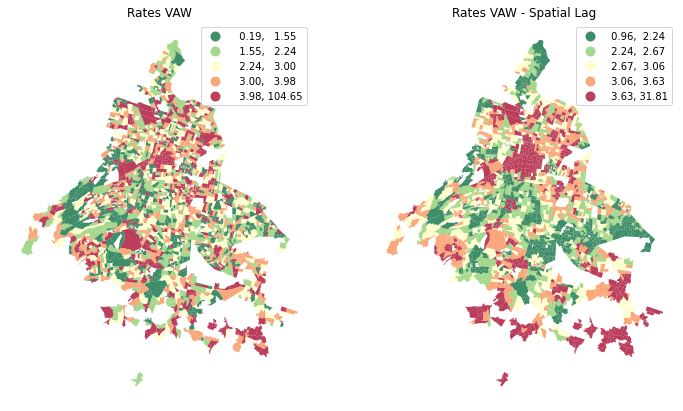

In [7]:
f, axs = plt.subplots(1, 2, figsize=(12, 12))
ax1, ax2 = axs

gdf.plot(
    column='VAW_per_1000',
    cmap='RdYlGn_r',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=True,
    ax=ax1
)
ax1.set_axis_off()
ax1.set_title("Rates VAW")

gdf.plot(
    column='VAW_per_1000_LAG',
    cmap='RdYlGn_r',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.,
    alpha=0.75,
    legend=True,
    ax=ax2
)
ax2.set_axis_off()
ax2.set_title("Rates VAW - Spatial Lag")

plt.show()

Note that clusters are more evident in the Spatial Lag map. This because spatial lags captures the wider geographical dependencies. 

Still a visual intuition though. How to prove that spatial autocorrelation is positive? 

The Moran's I anser to this question. If positive, then data have positive spatial autocorrelation, namely high values are close to high values and low values are close to low values. On the contrary, similar values are far from each other (negative spatial autocorrelation). 


In [8]:
# global autocorrelation for WAV per 1000
moran = Moran(gdf.VAW_per_1000, w_knn)

print("Moran's I: ", moran.I)

Moran's I:  0.1550478007421278


The Moran's I is bounded by -1 and 1, so 0.15 is not large, but it is still above zero. Therefore, there is a positive spatial autocorrelation between VAW locations. To be completly sure that patterns on map are not generated by a random process, I need to compute the Moran'I associated P-value.

In [9]:
print("P-value: ", moran.p_sim)

P-value:  0.001


Since the p-value is small enough, then I can reject the null hypothesis. Namely, the spatial patterns on VAW locations are not produced by random chance. 

All the above can be see using the Moran scatterplot. The graph will show the relationship between rates of VAW per 1000 and the average value of its neighbors for the same variable.

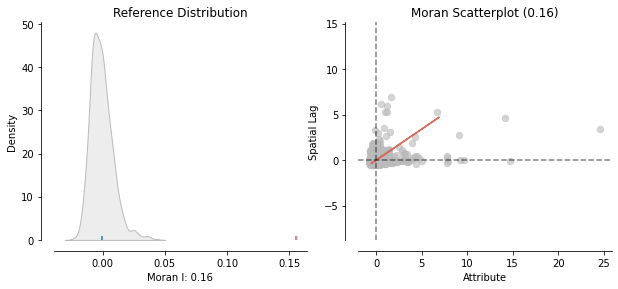

In [10]:
plot_moran(moran)
plt.show()

The red line direction of the Moran Scatterplot confirms the positive relationship and, overall, I can say that high rates of WAV tend to be associated with high local average values. In the upper-right quadrant are geographies where both the VAW rates and local average VAW rate are higher than the overall average value. Similarly, in the lower-left quadrant are cases where both the VAW rate and local average value of the VAW rate are lower than the overall average value.


Thanks to global autocorrelation, I know for a fact that our data do have a general pattern and they do not cluster by accident. But, I don't know yet if there is a local pattern. To find out that, run the local indicators of spatial association (LISA) analysis.

## Local Spatial Autocorrelation

Use `esda` to compute local Moran values.

In [11]:
lisa = esda.moran.Moran_Local(gdf.VAW_per_1000, w_knn)

As before, use the scatterplot to get a better insight.
LISA allows to decide the P-value for which consider the relationship to be significant. Set P-Value lower than 0.05.

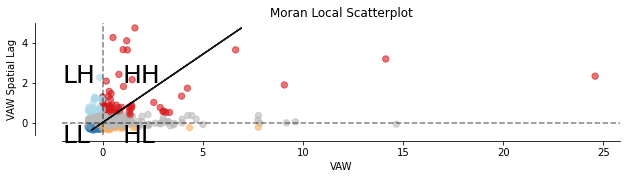

In [12]:
# Plot
fig,ax = plt.subplots(figsize=(10,12))
# set p-value: 0.05
moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("VAW")
ax.set_ylabel('VAW Spatial Lag')

# add some labels
plt.text(1, 2, "HH", fontsize=25)
plt.text(1, -1, "HL", fontsize=25)
plt.text(-2, 2, "LH", fontsize=25)
plt.text(-2, -1, "LL", fontsize=25)
plt.show()



In the figure above, the coloured points represents AGEBs that are statisticaly significantly, spatially autocorrelated for a P- Value less than 0.05. 

Finally, I can visually the clusters using the `lisa_cluster` function.
Here below, plot the Local Autocorrelation map for P-value < 0.05 and P-value < 0.01

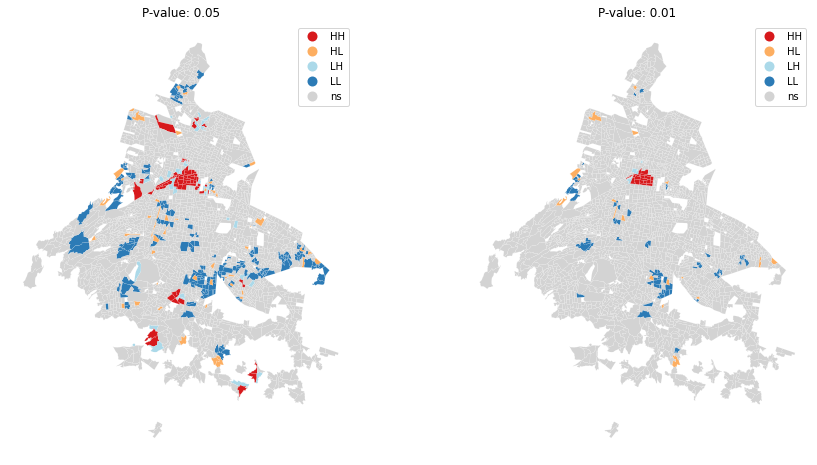

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# P -Value < 0.05 
lisa_cluster(lisa, gdf, p=0.05, ax=ax[0])

ax[0].axis("off")
ax[0].set_title("P-value: 0.05")

# P -Value < 0.01
lisa_cluster(lisa, gdf, p=0.01, ax=ax[1])
ax[1].axis("off")
ax[1].set_title("P-value: 0.01")

plt.show()

In [14]:
# Save data for future steps
gdf.to_file("data/VAW_AGEB_clean_lag.gjson", driver="GeoJSON")

From the figures, it can be seen that areas with HH and LL values are more frequent, further confirming the positive correlation between the VAW rate and where the violence took place. With P-value < 0.01, we can see where the relationship is stronger. 

Now we could examine the relationship between the VAW rate (dependent variable) and the explanatory variables (predictors) applying different spatial regression models to find which best describe our data. However, this is out of the scope of this project and I will keep the task as a future challenge. 

In the next step, I'll focus on the street network analysis to find the shortest path to reach the nearest Help Centre from each AGEB. 